In [4]:
!pip install nltk


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\GiaHyTran\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [1]:
import json
import time
import pandas as pd
from openai import OpenAI
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk

# Tải tài nguyên 'punkt' cần thiết cho NLTK
# NLTK sẽ tự động kiểm tra và chỉ tải nếu chưa có
print("Đang kiểm tra và tải tài nguyên 'punkt' cho NLTK...")
nltk.download('punkt')
print("Tải thành công!")

# Import TẤT CẢ các mẫu prompt từ file prompt.py
from prompt import *

Đang kiểm tra và tải tài nguyên 'punkt' cho NLTK...


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\GiaHyTran\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Tải thành công!


In [ ]:
# !!! QUAN TRỌNG: Hãy điền API Key của bạn vào đây
api_key = "..."  # Thay thế bằng API Key của bạn

# 1. Khởi tạo Client với API Key
client = OpenAI(api_key=api_key)

# 2. Định nghĩa các model và các kịch bản prompt
MODELS_TO_COMPARE = ["gpt-3.5-turbo", "gpt-4o-mini"]
PROMPTS_TO_TEST = {
    "English -> Persian": {
        "English Prompt (Zero-shot)": ENGLISH_ZERO,
        "English Prompt (1-shot)": ENGLISH_ONE,
        "English Prompt (3-shot)": ENGLISH_THREE,
        "Persian Prompt (Zero-shot)": PERSIAN_ZERO,
        "Persian Prompt (1-shot)": PERSIAN_ONE,
        "Persian Prompt (3-shot)": PERSIAN_THREE,
    }
    # phần "Persian -> English" vì không có dữ liệu
}

# 3. Tải và xử lý dữ liệu từ file MT.jsonl
try:
    full_data = []
    # Dùng đúng tên file dữ liệu bạn đã cung cấp
    with open('MT.jsonl', 'r', encoding='utf-8') as reader:
        for line in reader:
            full_data.append(json.loads(line))
    
    # 4. Tách dữ liệu theo chiều dịch dựa vào trường "type"
    en_to_fa_data = [item for item in full_data if item['type'] == 'En-Per']
    fa_to_en_data = [item for item in full_data if item['type'] == 'Per-En']
    
    # === THAY ĐỔI QUAN TRỌNG NHẤT ===
    SAMPLE_SIZE = 200 
    
    # Lấy một phần nhỏ của dữ liệu để chạy thử
    en_to_fa_sample = en_to_fa_data[:SAMPLE_SIZE]
    fa_to_en_sample = fa_to_en_data[:SAMPLE_SIZE]
    
    print(f"✅ Đã tải thành công {len(full_data)} cặp câu.")
    print(f"   -> Sử dụng {len(en_to_fa_sample)} mẫu cho chiều Anh -> Ba Tư.")
    print(f"   -> Sử dụng {len(fa_to_en_sample)} mẫu cho chiều Ba Tư -> Anh.")

except FileNotFoundError:
    print("❌ Lỗi: Không tìm thấy file 'MT.jsonl'.")

✅ Đã tải thành công 200 cặp câu.
   -> Sử dụng 200 mẫu cho chiều Anh -> Ba Tư.
   -> Sử dụng 0 mẫu cho chiều Ba Tư -> Anh.


In [3]:
def get_translation_from_model(prompt, model_name):
    """
    Hàm này nhận một prompt và tên model, sau đó trả về bản dịch.
    """
    try:
        response = client.chat.completions.create(
          model=model_name,
          messages=[
                {"role": "system", "content": "You are an expert translator."},
                {"role": "user", "content": prompt}
            ],
          temperature=0,
          max_tokens=256  # Tăng giới hạn token cho các câu dài
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"\nLỗi khi gọi model {model_name}: {e}")
        return "ERROR"

In [4]:
# Dictionary để lưu kết quả cuối cùng
final_results = {}
chencherry = SmoothingFunction()

# Dictionary để chứa dữ liệu mẫu cho mỗi tác vụ
tasks_data = {
    "English -> Persian": en_to_fa_sample,
    "Persian -> English": fa_to_en_sample
}

# Bắt đầu vòng lặp lớn
for task_name, prompts in PROMPTS_TO_TEST.items():
    print(f"\n==================== BẮT ĐẦU TÁC VỤ: {task_name} ====================")
    final_results[task_name] = {}
    
    current_data = tasks_data[task_name]
    if not current_data:
        print(f"Bỏ qua tác vụ {task_name} vì không có dữ liệu mẫu.")
        continue

    # Xác định ngôn ngữ nguồn và đích dựa trên tên tác vụ
    source_key, target_key, source_lang_name, target_lang_name = \
        ('En_sentence', 'Per_sentence', 'English', 'Persian') if task_name == "English -> Persian" else \
        ('Per_sentence', 'En_sentence', 'Persian', 'English')
    
    reference_translations = [sample[target_key] for sample in current_data]

    for model_name in MODELS_TO_COMPARE:
        final_results[task_name][model_name] = {}
        print(f"---------- Bắt đầu Model: {model_name} ----------")

        for prompt_name, prompt_template in prompts.items():
            print(f"--- 🚀 Đang chạy kịch bản: {prompt_name} ---")
            
            model_translations = []
            
            for sample in tqdm(current_data, desc=f"Querying {prompt_name}"):
                # Điền đầy đủ các thông tin vào prompt
                prompt = prompt_template.format(
                    source_language=source_lang_name,
                    target_language=target_lang_name,
                    input=sample[source_key]
                )
                answer = get_translation_from_model(prompt, model_name)
                model_translations.append(answer)
                time.sleep(1)

            # Tính điểm BLEU
            total_bleu = 0
            for ref, trans in zip(reference_translations, model_translations):
                # Tách từ cho câu tham chiếu và câu dịch (logic từ code gốc)
                ref_tokens = [ref.split()]
                trans_tokens = trans.split()
                total_bleu += sentence_bleu(ref_tokens, trans_tokens, smoothing_function=chencherry.method1)
            
            avg_bleu = (total_bleu / len(current_data)) * 100
            final_results[task_name][model_name][prompt_name] = avg_bleu
            print(f"--- 🎉 Hoàn thành. Điểm BLEU: {avg_bleu:.2f} ---\n")

print("✨ Đã hoàn thành tất cả các thử nghiệm.")


==================== BẮT ĐẦU TÁC VỤ: English -> Persian ====================
---------- Bắt đầu Model: gpt-3.5-turbo ----------
--- 🚀 Đang chạy kịch bản: English Prompt (Zero-shot) ---


Querying English Prompt (Zero-shot): 100%|██████████| 200/200 [07:19<00:00,  2.20s/it]


--- 🎉 Hoàn thành. Điểm BLEU: 7.17 ---

--- 🚀 Đang chạy kịch bản: English Prompt (1-shot) ---


Querying English Prompt (1-shot): 100%|██████████| 200/200 [07:15<00:00,  2.18s/it]


--- 🎉 Hoàn thành. Điểm BLEU: 6.95 ---

--- 🚀 Đang chạy kịch bản: English Prompt (3-shot) ---


Querying English Prompt (3-shot): 100%|██████████| 200/200 [07:25<00:00,  2.23s/it]


--- 🎉 Hoàn thành. Điểm BLEU: 6.72 ---

--- 🚀 Đang chạy kịch bản: Persian Prompt (Zero-shot) ---


Querying Persian Prompt (Zero-shot): 100%|██████████| 200/200 [07:43<00:00,  2.32s/it]


--- 🎉 Hoàn thành. Điểm BLEU: 4.94 ---

--- 🚀 Đang chạy kịch bản: Persian Prompt (1-shot) ---


Querying Persian Prompt (1-shot): 100%|██████████| 200/200 [07:27<00:00,  2.24s/it]


--- 🎉 Hoàn thành. Điểm BLEU: 5.03 ---

--- 🚀 Đang chạy kịch bản: Persian Prompt (3-shot) ---


Querying Persian Prompt (3-shot): 100%|██████████| 200/200 [07:11<00:00,  2.16s/it]


--- 🎉 Hoàn thành. Điểm BLEU: 6.70 ---

---------- Bắt đầu Model: gpt-4o-mini ----------
--- 🚀 Đang chạy kịch bản: English Prompt (Zero-shot) ---


Querying English Prompt (Zero-shot): 100%|██████████| 200/200 [07:23<00:00,  2.22s/it]


--- 🎉 Hoàn thành. Điểm BLEU: 8.79 ---

--- 🚀 Đang chạy kịch bản: English Prompt (1-shot) ---


Querying English Prompt (1-shot): 100%|██████████| 200/200 [07:33<00:00,  2.27s/it]


--- 🎉 Hoàn thành. Điểm BLEU: 8.78 ---

--- 🚀 Đang chạy kịch bản: English Prompt (3-shot) ---


Querying English Prompt (3-shot): 100%|██████████| 200/200 [07:48<00:00,  2.34s/it]


--- 🎉 Hoàn thành. Điểm BLEU: 8.43 ---

--- 🚀 Đang chạy kịch bản: Persian Prompt (Zero-shot) ---


Querying Persian Prompt (Zero-shot): 100%|██████████| 200/200 [07:43<00:00,  2.32s/it]


--- 🎉 Hoàn thành. Điểm BLEU: 8.54 ---

--- 🚀 Đang chạy kịch bản: Persian Prompt (1-shot) ---


Querying Persian Prompt (1-shot): 100%|██████████| 200/200 [07:38<00:00,  2.29s/it]


--- 🎉 Hoàn thành. Điểm BLEU: 8.47 ---

--- 🚀 Đang chạy kịch bản: Persian Prompt (3-shot) ---


Querying Persian Prompt (3-shot): 100%|██████████| 200/200 [07:27<00:00,  2.24s/it]

--- 🎉 Hoàn thành. Điểm BLEU: 8.82 ---

✨ Đã hoàn thành tất cả các thử nghiệm.


In [5]:
print(prompt)


  شرح وظیفه:
  در ادامه‌، وظیفه‌ (تکلیفی) برای شما درنظر گرفته شده است، که مربوط به ترجمه ماشینی است.
  به این منظور جمله‌ای به زبان English به شما نشان داده می‌شود  
  در نتیجه، شما باید آن جمله را به شکل مناسب و دقیق به زبان Persian ترجمه کنید.

  مثال‌هایی از ترجمه‌ی جملات نمونه از زبان English به Persian:
  'I love programming.'
  ->'من برنامه‌نویسی را دوست دارم.'
  'Cooking a delicious meal requires a combination of ingredients and techniques.'
  -> 'پخت یک وعده غذای خوشمزه نیازمند ترکیبی از مواد اولیه و تکنیک‌هاست.'
  'In the realm of artificial intelligence, neural networks play a pivotal role.'
  -> 'در دنیای هوش مصنوعی، شبکه‌های عصبی نقشی کلیدی ایفا می‌کنند.'

  ورودی:
  all the papers were ready for Richard down at Aldmixton whenever the time came; the Labour Government she meant.
  


In [6]:
print("\n\n📊=============== BẢNG SO SÁNH HIỆU NĂNG DỊCH MÁY (ĐIỂM BLEU) ===============📊")

# Chuẩn bị dữ liệu để tạo DataFrame
table_data = []
for task_name, model_results in final_results.items():
    for model_name, prompt_results in model_results.items():
        for prompt_name, bleu_score in prompt_results.items():
            table_data.append({
                "Tác vụ Dịch (Task)": task_name,
                "Model": model_name,
                "Kịch bản Prompt": prompt_name,
                "Điểm BLEU": f"{bleu_score:.2f}"
            })

# Tạo DataFrame từ pandas
summary_df = pd.DataFrame(table_data)

# Dùng pivot_table để có định dạng bảng đẹp hơn
pivot_df = summary_df.pivot_table(index=["Tác vụ Dịch (Task)", "Kịch bản Prompt"], 
                                  columns="Model", 
                                  values="Điểm BLEU",
                                  aggfunc='first')

# In ra bảng dưới dạng Markdown
print(pivot_df.to_markdown())



📊=============== BẢNG SO SÁNH HIỆU NĂNG DỊCH MÁY (ĐIỂM BLEU) ===============📊
|                                                      |   gpt-3.5-turbo |   gpt-4o-mini |
|:-----------------------------------------------------|----------------:|--------------:|
| ('English -> Persian', 'English Prompt (1-shot)')    |            6.95 |          8.78 |
| ('English -> Persian', 'English Prompt (3-shot)')    |            6.72 |          8.43 |
| ('English -> Persian', 'English Prompt (Zero-shot)') |            7.17 |          8.79 |
| ('English -> Persian', 'Persian Prompt (1-shot)')    |            5.03 |          8.47 |
| ('English -> Persian', 'Persian Prompt (3-shot)')    |            6.7  |          8.82 |
| ('English -> Persian', 'Persian Prompt (Zero-shot)') |            4.94 |          8.54 |


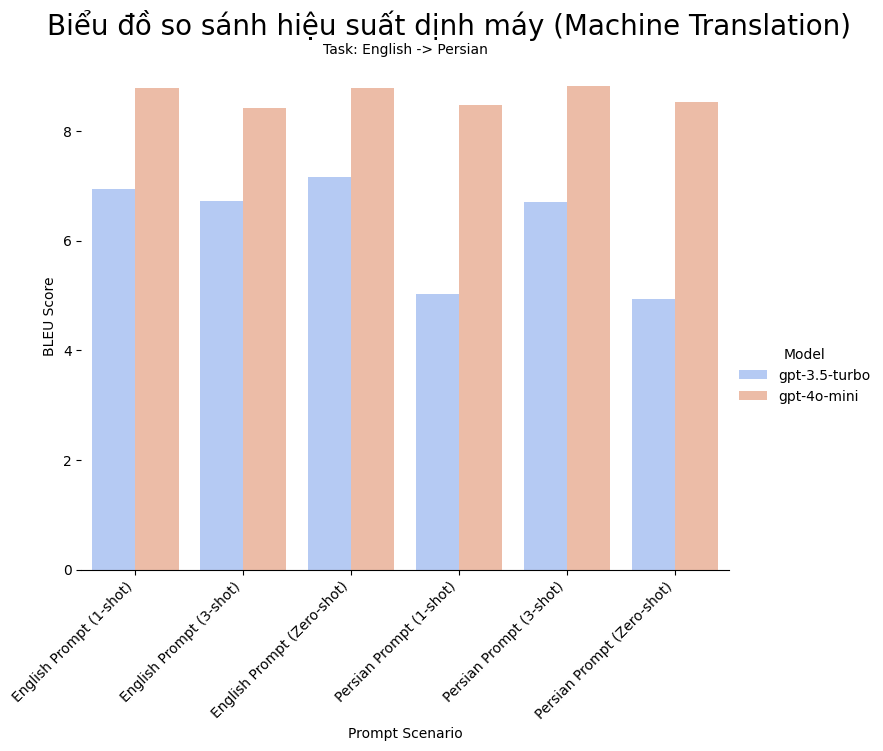

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Dữ liệu hiệu suất BLEU 
mt_data = {
    'Model': [
        'gpt-3.5-turbo', 'gpt-3.5-turbo', 'gpt-3.5-turbo', 'gpt-3.5-turbo', 'gpt-3.5-turbo', 'gpt-3.5-turbo',
        'gpt-4o-mini', 'gpt-4o-mini', 'gpt-4o-mini', 'gpt-4o-mini', 'gpt-4o-mini', 'gpt-4o-mini'
    ],
    'Task': [
        'English -> Persian', 'English -> Persian', 'English -> Persian',
        'English -> Persian', 'English -> Persian', 'English -> Persian',
        'English -> Persian', 'English -> Persian', 'English -> Persian',
        'English -> Persian', 'English -> Persian', 'English -> Persian'
    ],
    'Prompt': [
        'English Prompt (1-shot)', 'English Prompt (3-shot)', 'English Prompt (Zero-shot)',
        'Persian Prompt (1-shot)', 'Persian Prompt (3-shot)', 'Persian Prompt (Zero-shot)',
        'English Prompt (1-shot)', 'English Prompt (3-shot)', 'English Prompt (Zero-shot)',
        'Persian Prompt (1-shot)', 'Persian Prompt (3-shot)', 'Persian Prompt (Zero-shot)'
    ],
    'BLEU_Score': [
        # gpt-3.5-turbo scores
        6.95, 6.72, 7.17, 5.03, 6.70, 4.94,
        # gpt-4o-mini scores
        8.78, 8.43, 8.79, 8.47, 8.82, 8.54
    ]
}

df_mt = pd.DataFrame(mt_data)

# --- Vẽ biểu đồ so sánh ---
g = sns.catplot(
    data=df_mt, 
    x='Prompt', 
    y='BLEU_Score', 
    hue='Model', 
    col='Task',        # 'col' sẽ tạo ra các cột riêng cho mỗi Task
    kind='bar',        # Chỉ định loại biểu đồ là 'bar'
    palette='coolwarm',
    height=6,          # Chiều cao của mỗi biểu đồ con
    aspect=1.2         # Tỷ lệ chiều rộng/chiều cao
)

# Tùy chỉnh biểu đồ (bằng tiếng Anh)
g.fig.suptitle('Biểu đồ so sánh hiệu suất dịnh máy (Machine Translation)', fontsize=20, y=1.03)
g.set_axis_labels("Prompt Scenario", "BLEU Score")
g.set_titles("Task: {col_name}")
g.set_xticklabels(rotation=45, ha='right')
g.despine(left=True)

plt.show()

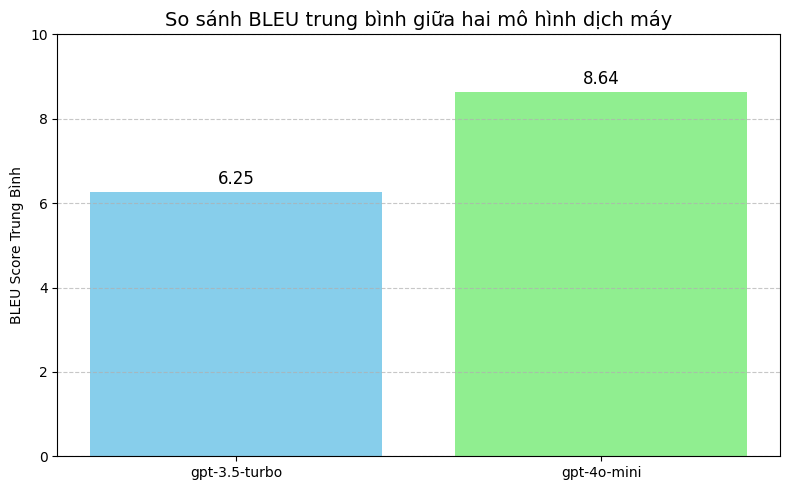

In [1]:
import matplotlib.pyplot as plt

# BLEU Scores từ bảng
gpt_35_turbo_scores = [6.95, 6.72, 7.17, 5.03, 6.7, 4.94]
gpt_4o_mini_scores = [8.78, 8.43, 8.79, 8.47, 8.82, 8.54]

# Tính BLEU trung bình
average_gpt_35_turbo = sum(gpt_35_turbo_scores) / len(gpt_35_turbo_scores)
average_gpt_4o_mini = sum(gpt_4o_mini_scores) / len(gpt_4o_mini_scores)

# Dữ liệu để vẽ biểu đồ
models = ['gpt-3.5-turbo', 'gpt-4o-mini']
bleu_scores = [average_gpt_35_turbo, average_gpt_4o_mini]

# Vẽ biểu đồ
plt.figure(figsize=(8, 5))
bars = plt.bar(models, bleu_scores, color=['skyblue', 'lightgreen'])

# Thêm nhãn số lên mỗi cột
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.1,
             f'{height:.2f}', ha='center', va='bottom', fontsize=12)

# Tùy chỉnh biểu đồ
plt.title('So sánh BLEU trung bình giữa hai mô hình dịch máy', fontsize=14)
plt.ylabel('BLEU Score Trung Bình')
plt.ylim(0, 10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()
